# ЛР 3 (Задание 1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Загрузка датасета
### Pet's Faces Dataset
Используем упрощенный датасет Oxford-IIIT Dataset с вырезанными лицами домашних животных. Для начала загружаем его:

In [ ]:
import pathlib

dataset_url = "https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz"
data_dir = tf.keras.utils.get_file('petfaces', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

24494080/24483412 [==============================] - 2s 0us/step


Всего у нас столько изображений.

In [ ]:
img_count = len(list(data_dir.glob('*/*.jpg')))
print(img_count)

3211


## Сплит исходного датасета

In [ ]:
batch_size = 64
img_height = 128
img_width = 128

Трейн датасет

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=66,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3211 files belonging to 35 classes.
Using 2409 files for training.


Тестовый датасет составит 25% от исходного датасета

In [ ]:
validation_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=66,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3211 files belonging to 35 classes.
Using 802 files for validation.


Посмотрим названия имеющихся классы, с которыми будем дальше работать.

In [ ]:
class_names = train_data.class_names
print(class_names)

['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx', 'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']


Распарсим классы собак и кошек и сохраним их индексы.

In [ ]:
cats_classes = []
dogs_classes = []

for i, class_name in enumerate(class_names):
    if class_name[:3] == 'cat':
        cats_classes.append(i)
    elif class_name[:3] == 'dog':
        dogs_classes.append(i)
    else:
        print('Error')

print("Cats' classes:", cats_classes)
print("Dogs' classes:", dogs_classes)

Cats' classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Dogs' classes: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


#### Сохранение датасета в кеш

Сохраним датасет в кеш, чтобы при обучении модели быстрее загружать изображения.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

## Обучение моделей

Архитектура нашей нейронной сети будет следующей:  
4x [Свертка + пулинг] > Dense > Dropout > Softmax

Сначала сделаем аугментацию (дополнение датасета) картинок - случайный поворот по горизонтали относительно вертикальной оси, случайный поворот или зум.  
Затем нормализуем картинки, приведя все числа в интервал [0; 1].

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.13),
    layers.RandomZoom(0.13),
])

In [ ]:
amount_classes = len(class_names)

conv_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(96, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.21),
    layers.Dense(amount_classes),
    layers.Softmax()
])

Будем проверять правильность предсказывания нашей модели на основе метрик точности и топ3 точности.

In [ ]:
top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')

conv_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', top3_acc])

Посмотрим, как выглядит наша нейронная сеть на каждом этапе.

In [ ]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  

Будем обучать на GPU для ускорения процесса обучения.

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [30]:
epochs = 50

history = conv_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs
)

Epoch 1/50
38/38 [==============================] - 2s 42ms/step - loss: 0.1699 - accuracy: 0.9518 - top_3_accuracy: 0.9958 - val_loss: 2.0444 - val_accuracy: 0.6783 - val_top_3_accuracy: 0.8616
Epoch 2/50
38/38 [==============================] - 2s 41ms/step - loss: 0.1386 - accuracy: 0.9502 - top_3_accuracy: 0.9971 - val_loss: 1.9020 - val_accuracy: 0.7032 - val_top_3_accuracy: 0.8691
Epoch 3/50
38/38 [==============================] - 2s 45ms/step - loss: 0.1467 - accuracy: 0.9452 - top_3_accuracy: 0.9954 - val_loss: 1.9356 - val_accuracy: 0.7045 - val_top_3_accuracy: 0.8791
Epoch 4/50
38/38 [==============================] - 2s 50ms/step - loss: 0.1625 - accuracy: 0.9440 - top_3_accuracy: 0.9950 - val_loss: 1.9084 - val_accuracy: 0.6808 - val_top_3_accuracy: 0.8766
Epoch 5/50
38/38 [==============================] - 2s 47ms/step - loss: 0.1656 - accuracy: 0.9444 - top_3_accuracy: 0.9946 - val_loss: 1.9679 - val_accuracy: 0.6733 - val_top_3_accuracy: 0.8653
Epoch 6/50
38/38 [=======

Получили точность в 67%, топ3 точность в 86%, то есть с 86% шансом правильный класс будет среди трёх наиболее вероятных классов, предсказанных моделью.

## Графики для метрик

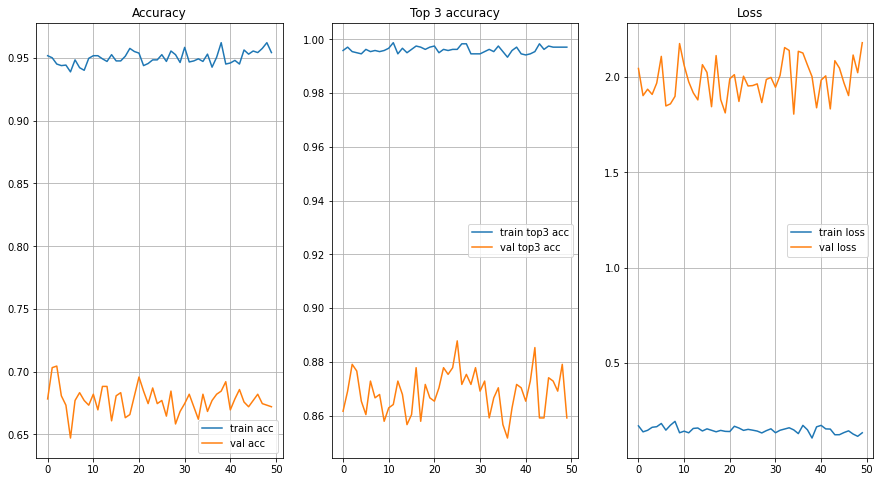

In [31]:
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

top3_acc = history.history['top_3_accuracy']
validation_top3_acc = history.history['val_top_3_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, validation_acc, label='val acc')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, top3_acc, label='train top3 acc')
plt.plot(epochs_range, validation_top3_acc, label='val top3 acc')
plt.legend()
plt.grid()
plt.title('Top 3 accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, validation_loss, label='val loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.show()

Посчитаем точность бинарной классификации - кошки vs собаки

In [32]:
def count_binary_accuracy(model, validation_data):
    correct_predictions = 0
    total_labels = 0

    for X, y in validation_data:
        y_pred = np.argmax(model.predict(X), axis=1)
        correct_cats = sum([y_pred[i] in cats_classes and y[i] in cats_classes for i in range(len(y))])
        correct_dogs = sum([y_pred[i] in dogs_classes and y[i] in dogs_classes for i in range(len(y))])
        correct_predictions += correct_cats + correct_dogs
        total_labels += len(y)
    return correct_predictions / total_labels

In [33]:
print('Cats vs dogs accuracy =', count_binary_accuracy(conv_model, validation_data))

Cats vs dogs accuracy = 0.9538653366583542


Как мы видим, наша модель научилась правильно различать кошек от собак в 95% случаях.

Построим матрицу неточности.

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
def plot_confusion_matrix(model, val):
    y_real = np.array([])
    y_pred = np.array([])

    for x, y in val:
        y_real = np.concatenate((y_real, y), axis=None)
        y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    
    conf_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=amount_classes)
    
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in class_names], columns = [i for i in class_names], dtype = np.int32)
    plt.figure(figsize = (15, 15))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

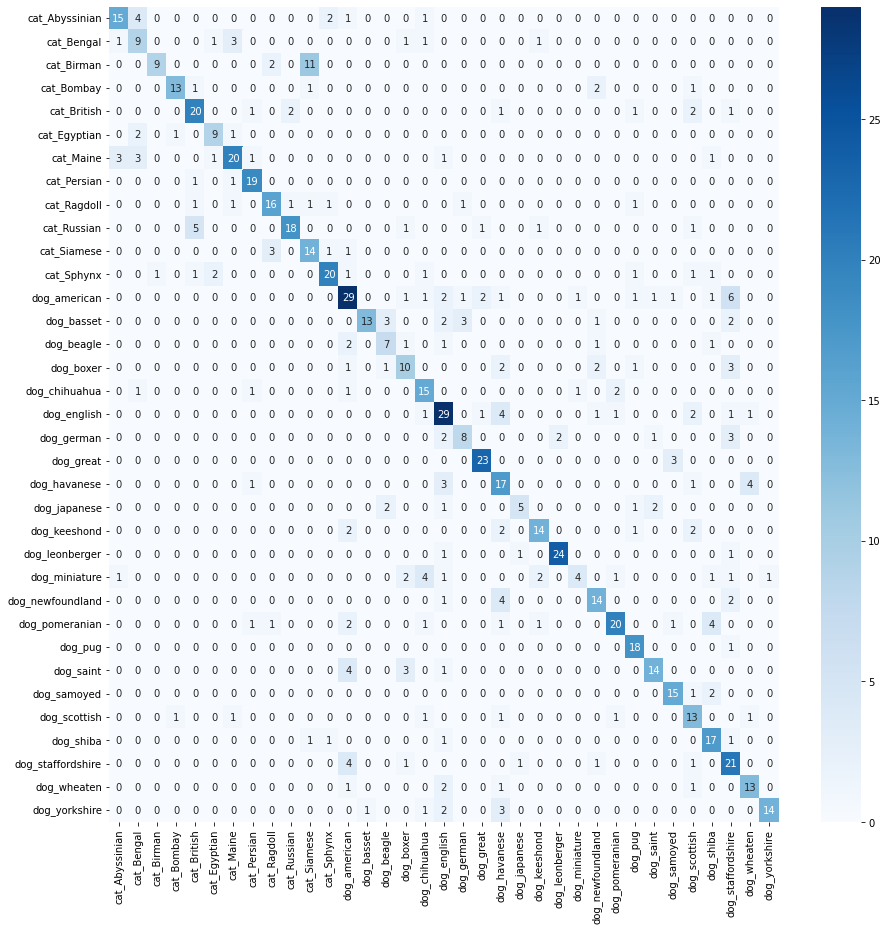

In [35]:
plot_confusion_matrix(conv_model, validation_data)

## Выводы

Итак, соберём в одном месте все метрики модели.  
**Метрики на вале**:  
Точность = 0.67  
Топ3 точность = 0.86  
Точность бинарной классификации = 0.95

Получили неплохие результаты, однако мы могли расширить датасет для повышения точности предсказаний.